# Tutorial home sales

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
# Grid Search

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : Has been viewed
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
addr = "./data/"
df_train = pd.read_csv(os.path.join(addr,'train.csv'))
df_test = pd.read_csv(os.path.join(addr,'test.csv'))

df_train.info()

df_train.head()

df_test.info()

df_test.head()

# EDA

#### 1. Check missing data

def check_missing(df):
    print("Number of Missing data at each column")
    for column in df.columns:
        a = df[column].isnull().sum()
        print(f"{column:20} :{a}")

check_missing(df_train)
print()
check_missing(df_test)

df_train.drop(['sqft_living', 'sqft_lot'],axis=1, inplace=True)
df_test.drop(['sqft_living', 'sqft_lot'], axis=1, inplace=True)

df_train.shape, df_test.shape

In [3]:
df_train["date"] = df_train["date"].apply(lambda x: int(x[:8]))
df_test["date"] = df_test["date"].apply(lambda x: int(x[:8]))

In [4]:
df_train["year"] = df_train.date.apply(lambda x: x // 10000)
df_train["month"] = df_train.date.apply(lambda x: (x%10000) // 100)
df_test["year"] = df_test.date.apply(lambda x: x // 10000)
df_test["month"] = df_test.date.apply(lambda x: (x%10000) // 100)

In [5]:
df_train.drop(["date"],axis=1, inplace=True)
df_test.drop(["date"],axis=1, inplace=True)

lambda_fn = lambda row : row['year'] - row['yr_renovated'] if row['yr_renovated'] else row['year'] - row['yr_built']
df_train["age"] = df_train.apply(lambda_fn, axis=1)
df_test["age"] = df_test.apply(lambda_fn, axis=1)

df_train.columns

grid=sns.FacetGrid(df_train,row="bedrooms",height=5,aspect=1)
g=(grid.map(plt.scatter,"sqft_living","price").add_legend())

sns.relplot(x='sqft_living',y='price',hue='view', data=df_train)

def catplot(col):
    sns.catplot(x=col, y='price', data=df_train)

sns.catplot(x='view', y='price', data=df_train, hue="bedrooms")

df_train.loc[(df_train['condition'] <=2)&(df_train['bedrooms']<=5)]

sns.relplot(x='zipcode',y='price',data=df_train)

zip_index = df_train.loc[df_train['price']>=2000000].groupby('zipcode').sum().index

df_train['mask_zipcode'] = df_train['zipcode'].apply(lambda x: 1 if x in zip_index else 0)
df_test['mask_zipcode'] = df_test['zipcode'].apply(lambda x: 1 if x in zip_index else 0)

from sklearn.preprocessing import minmax_scale

df_train.head()

#### one-hot encoding

df_train = pd.get_dummies(df_train, columns=["zipcode"], prefix="zip")
df_test = pd.get_dummies(df_test, columns=["zipcode"], prefix="zip")

In [6]:
df_train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,0,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,1,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
2,2,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
3,3,257500.0,3,2.25,1715,6819,2.0,0,0,3,...,0,1995,0,98003,47.3097,-122.327,2238,6819,2014,6
4,4,291850.0,3,1.50,1060,9711,1.0,0,0,3,...,0,1963,0,98198,47.4095,-122.315,1650,9711,2015,1


In [7]:
y_tr = df_train['price']
df_train2 = df_train.drop(['id', 'price'], axis=1)
df_test2 = df_test.drop(['id'], axis=1)

In [8]:
X, y = df_train2.values, y_tr.values
X_t = df_test2.values

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import xgboost as xgb
import lightgbm as lgb
gboost = GradientBoostingRegressor(random_state=20190314)
xgboost = xgb.XGBRegressor(random_state=20190314)
lightgbm = lgb.LGBMRegressor(random_state=20190314)

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [10]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], X, y)), 
                                             cv=5))

In [11]:
get_cv_score(models)

/home/son/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model GradientBoosting CV score : 0.8582


/home/son/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model XGBoost CV score : 0.8521


/home/son/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Model LightGBM CV score : 0.8744


In [12]:
lightgbm.fit(X,y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=20190314, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
pred = lightgbm.predict(X)

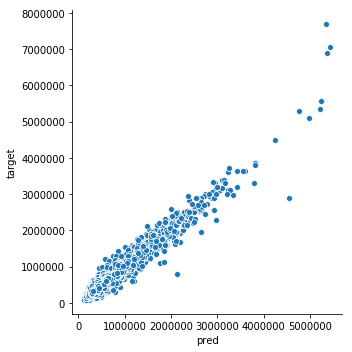

In [14]:
tmp_df = pd.DataFrame({'pred':pred, 'target':y})
sns.relplot(x='pred', y='target', data=tmp_df)

## DATA Split

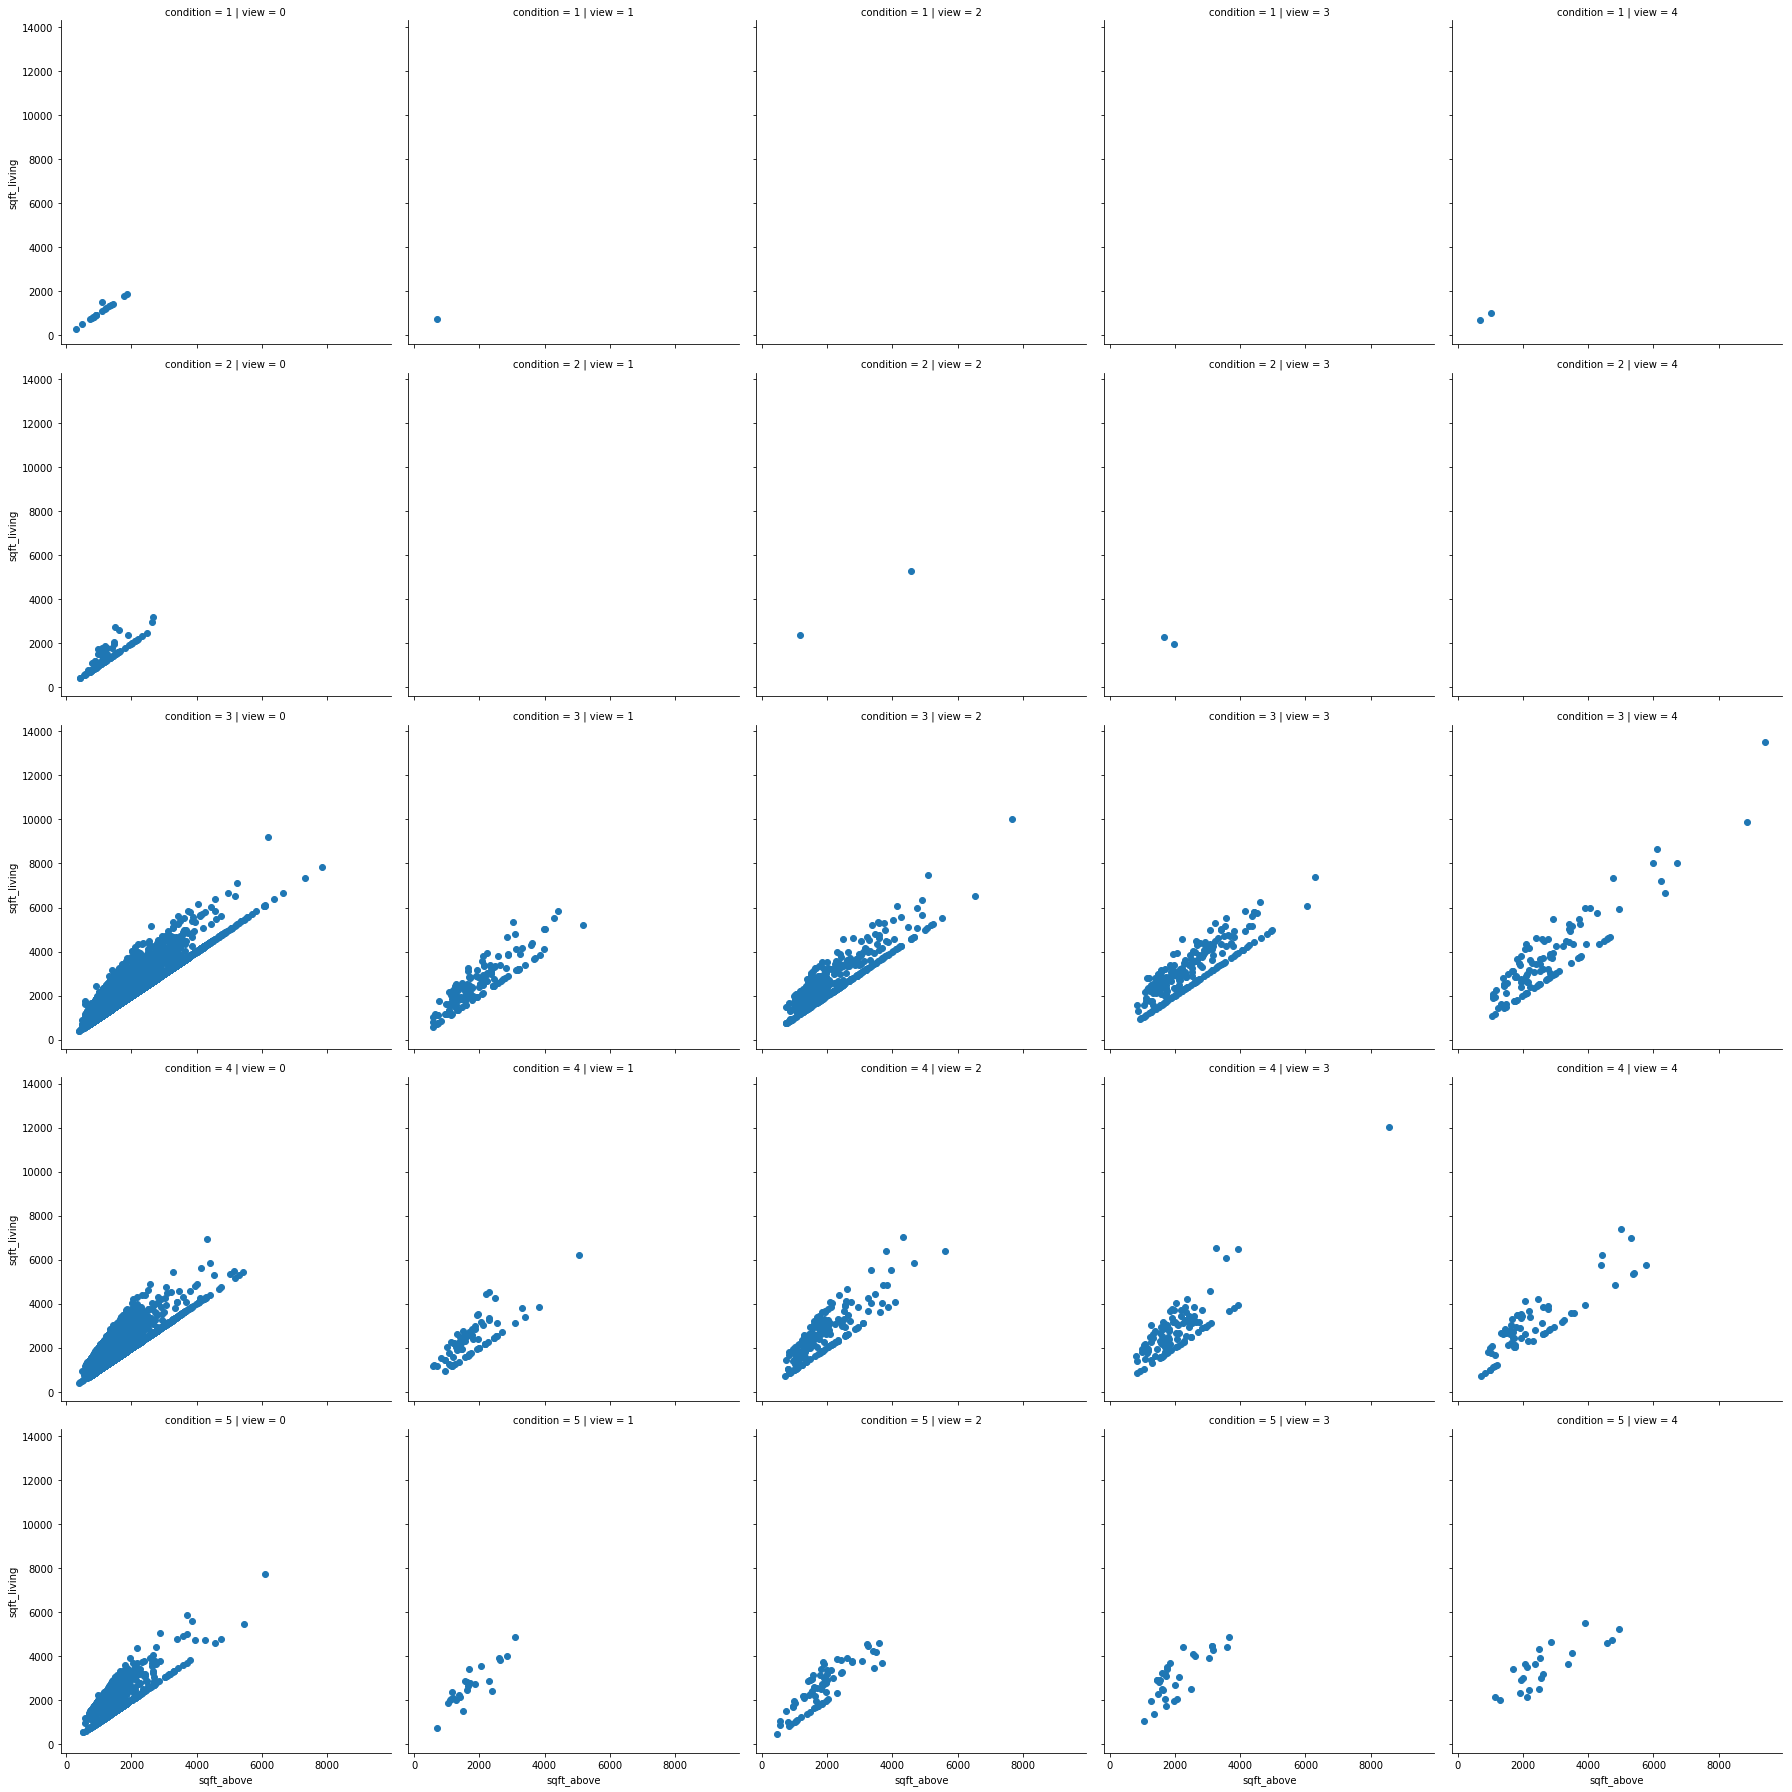

In [23]:
grid=sns.FacetGrid(df_train,row="condition",col="view",height=5,aspect=1)
g=(grid.map(plt.scatter,"sqft_above","sqft_living"))

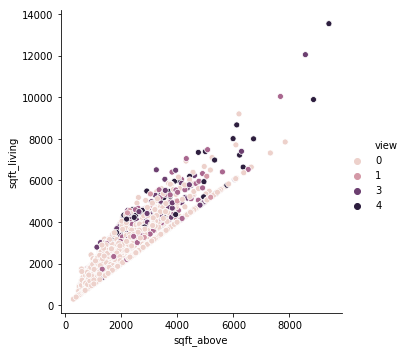

In [28]:
sns.relplot(x='sqft_above', y='sqft_living', hue='view', data=df_train)

In [32]:
par1 = df_train.loc[df_train['sqft_living'] > df_train['sqft_above']]
par2 = df_train.drop(par1.index.tolist())

In [33]:
par1.shape, par2.shape

((5892, 22), (9143, 22))

In [34]:
par1_t = df_test.loc[(df_test['view'] == 0) & (df_test['condition'] <= 3)]
par2_t = df_test.drop(par1_t.index.tolist())

In [35]:
idx_list = [par1.index, par2.index]
idx_t_list = [par1_t.index, par2_t.index]

In [36]:
X_list = []
for i in range(len(idx_list)):
    X_list.append(X[idx_list[i]])

X_t_list= []
for i in range(len(idx_list)):
    X_t_list.append(X_t[idx_t_list[i]])

In [37]:
y_list = []
for i in range(len(idx_list)):
    y_list.append(y[idx_list[i]])

In [38]:
model_list = [
            lgb.LGBMRegressor(random_state=20190314),
            lgb.LGBMRegressor(random_state=20190314)
             ]

In [39]:
result = []
for i in range(len(idx_list)):
    model_list[i].fit(X_list[i],y_list[i])
    result.append(model_list[i].predict(X_list[i]))
pred_sep = np.zeros(15035)

In [40]:
for i in range(len(idx_list)):
    pred_sep[idx_list[i]] = result[i]

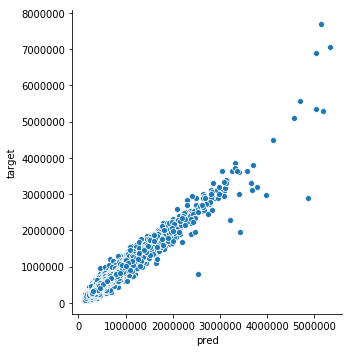

In [41]:
tmp_df = pd.DataFrame({'pred':pred_sep, 'target':y})
sns.relplot(x='pred', y='target', data=tmp_df)

In [42]:
from sklearn.metrics import r2_score, mean_squared_error

In [43]:
r2_score(pred_sep, y)

0.9479064637988759

In [44]:
mean_squared_error(pred_sep,y)**0.5

81138.1662996425

In [ ]:
df1 = df_train.iloc[a]

In [ ]:
df2 = df_train.iloc[b]

In [ ]:
cross_val_score(model_list[2], X_list[2], y_list[2], cv=5, scoring='r2')

In [ ]:
model_list[0].get_params()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:

param_grid = {'alpha':[0.01, 0.1, 1, 10, 100], 'normalize':[True, False]}
grid = GridSearchCV(cv=5, estimator=model_list[0], param_grid=param_grid, scoring='r2')

In [ ]:
grid.fit(X_list[0],y_list[0])

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
model_list[2].get_params()

In [ ]:

param_grid = {'learning_rate':[0.01, 0.1], 'n_estimators':[100, 150, 180], 'max_depth':[ 9, 10, 11 -1]}
grid = GridSearchCV(cv=5, estimator=model_list[3], param_grid=param_grid, scoring='r2')

In [ ]:
grid.fit(X_list[3], y_list[3])

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
params.append(grid.best_params_)

In [ ]:
params

In [ ]:
result = []
for i in range(len(idx_list)):
    result.append(model_list[i].predict(X_t_list[i]))
pred_sep = np.zeros(df_test.shape[0])

In [ ]:
for i in range(len(idx_list)):
    pred_sep[idx_t_list[i]] = result[i]

In [ ]:
pred_sep

In [ ]:
sub = pd.DataFrame({'id':df_test['id'], 'price':pred_sep})
sub.to_csv("submission2.csv", index=False)